In [10]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [11]:
HERE = Path.cwd()
ROOT = HERE.parent
print(ROOT)

/home/james/code/deep_learning_developments_with_pytorch_final_project


In [12]:
CSV_PATH = ROOT / 'aggregated_results.csv'

ALGO = 'sac'
ENV_ID = 'Hopper-v5'

WEIGHTS_WHITELIST = ['baseline', 'ga2']

AGENT_WEIGHTS = 'ga2'
AGENT_SEED = 1


In [13]:
# Load CSV
df = pd.read_csv(CSV_PATH)

required_cols = {
    "algo",
    "env_id",
    "seed",
    "episode_index",
    "episodic_return",
    "episode_length",
    "max_episode_steps",
    "duration_rate",
    "weights",   # e.g. baseline / ga1 / ga2
}
missing = required_cols - set(df.columns)
if missing:
    raise ValueError(f"CSV is missing required columns: {missing}")

# Filter to the chosen algo + env
mask = (df["algo"] == ALGO) & (df["env_id"] == ENV_ID)
df_sel = df[mask].copy()

print(f"Total rows for {ALGO} on {ENV_ID}: {len(df_sel)}")
print("Unique weights configs:", sorted(df_sel["weights"].unique()))
print("Unique seeds:", sorted(df_sel["seed"].unique()))


Total rows for sac on Hopper-v5: 3000
Unique weights configs: ['baseline', 'ga1', 'ga2']
Unique seeds: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10)]


In [14]:
# Optionally restrict to some weights configs
if WEIGHTS_WHITELIST is not None:
    df_sel = df_sel[df_sel["weights"].isin(WEIGHTS_WHITELIST)].copy()

# Just sanity
if df_sel.empty:
    raise ValueError("No rows after filtering by algo/env/weights — check config.")

# Per-(weights, seed) stats over episodes
group_cols = ["weights", "seed"]
stats = (
    df_sel
    .groupby(group_cols)["episodic_return"]
    .agg(["mean", "std", "count"])
    .reset_index()
    .rename(columns={"mean": "return_mean", "std": "return_std", "count": "num_episodes"})
)

print("Per-agent stats (head):")
display(stats.head())


Per-agent stats (head):


,weights,seed,return_mean,return_std,num_episodes
0,baseline,1,999.662219,81.514653,100
1,baseline,2,2339.621530,798.290433,100
2,baseline,3,839.408818,203.391779,100
3,baseline,4,3121.240695,513.159502,100
4,baseline,5,993.432407,107.196783,100


Seeds in this (algo, env): [ 1  2  3  4  5  6  7  8  9 10]
Configs (weights): ['baseline', 'ga2']


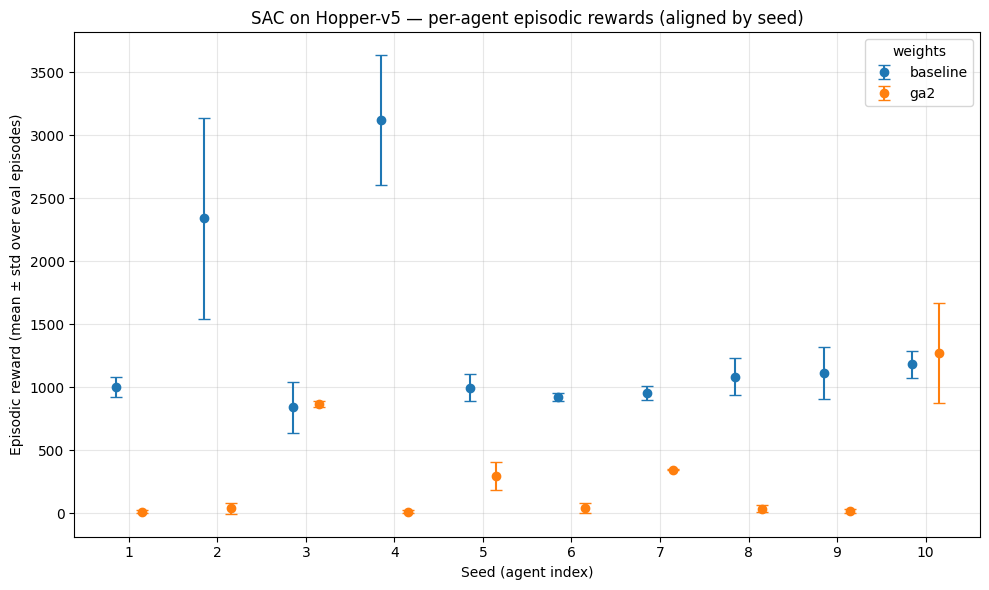

In [15]:
# Pivot so that each (seed) has columns per weights config
pivot_mean = stats.pivot(index="seed", columns="weights", values="return_mean")
pivot_std  = stats.pivot(index="seed", columns="weights", values="return_std")

seeds = pivot_mean.index.to_numpy()
configs = list(pivot_mean.columns)

print("Seeds in this (algo, env):", seeds)
print("Configs (weights):", configs)

plt.figure(figsize=(10, 6))

# Offsets to separate configs horizontally a bit
offsets = np.linspace(-0.15, 0.15, len(configs))

for i, cfg in enumerate(configs):
    x = seeds + offsets[i]
    y = pivot_mean[cfg].to_numpy()
    yerr = pivot_std[cfg].to_numpy()

    plt.errorbar(
        x,
        y,
        yerr=yerr,
        fmt="o",
        capsize=4,
        label=str(cfg),
    )

plt.xticks(seeds, seeds)
plt.xlabel("Seed (agent index)")
plt.ylabel("Episodic reward (mean ± std over eval episodes)")
plt.title(f"{ALGO.upper()} on {ENV_ID} — per-agent episodic rewards (aligned by seed)")
plt.legend(title="weights")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(fr'{str(ROOT / "figures")}/{ALGO}_hopper_per_agent_rewards', dpi=300, bbox_inches='tight')
plt.show()


In [16]:
# Filter to a single agent: one weights config + one seed
agent_mask = (df_sel["weights"] == AGENT_WEIGHTS) & (df_sel["seed"] == AGENT_SEED)
agent_df = df_sel[agent_mask].copy()

if agent_df.empty:
    raise ValueError(
        f"No rows found for weights={AGENT_WEIGHTS!r}, seed={AGENT_SEED} "
        f"under algo={ALGO}, env={ENV_ID}"
    )

print(
    f"Agent selection: algo={ALGO}, env={ENV_ID}, "
    f"weights={AGENT_WEIGHTS}, seed={AGENT_SEED}, "
    f"{len(agent_df)} episodes"
)

agent_returns = agent_df["episodic_return"].to_numpy(dtype=float)
agent_lengths = agent_df["episode_length"].to_numpy(dtype=float)
per_step_rewards = agent_returns / agent_lengths

print("Episodic return summary:")
display(pd.Series(agent_returns).describe())

print("\nPer-step reward summary:")
display(pd.Series(per_step_rewards).describe())


Agent selection: algo=sac, env=Hopper-v5, weights=ga2, seed=1, 100 episodes
Episodic return summary:


count    100.000000
mean      11.700518
std       11.134406
min        2.451328
25%        6.095324
50%        8.978858
75%       13.029600
max       96.286144
dtype: float64


Per-step reward summary:


count    100.000000
mean       0.682430
std        0.201305
min        0.310337
25%        0.569339
50%        0.656892
75%        0.740368
max        1.604769
dtype: float64

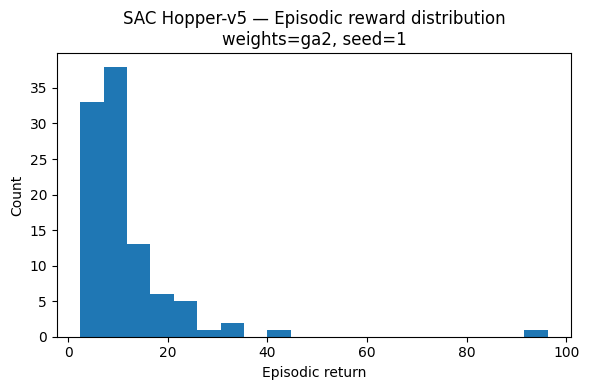

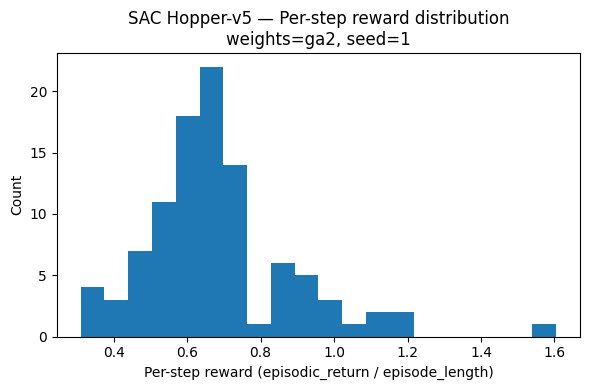

In [17]:
# Histogram of episodic returns
plt.figure(figsize=(6, 4))
plt.hist(agent_returns, bins=20)
plt.xlabel("Episodic return")
plt.ylabel("Count")
plt.title(
    f"{ALGO.upper()} {ENV_ID} — Episodic reward distribution\n"
    f"weights={AGENT_WEIGHTS}, seed={AGENT_SEED}"
)
plt.tight_layout()
plt.savefig(fr'{str(ROOT / "figures")}/{ALGO}_hopper_hist_episodic_rewards', dpi=300, bbox_inches='tight')
plt.show()

# Histogram of per-step rewards
plt.figure(figsize=(6, 4))
plt.hist(per_step_rewards, bins=20)
plt.xlabel("Per-step reward (episodic_return / episode_length)")
plt.ylabel("Count")
plt.title(
    f"{ALGO.upper()} {ENV_ID} — Per-step reward distribution\n"
    f"weights={AGENT_WEIGHTS}, seed={AGENT_SEED}"
)
plt.tight_layout()
plt.savefig(fr'{str(ROOT / "figures")}/{ALGO}_hopper_hist_per_step_rewards', dpi=300, bbox_inches='tight')
plt.show()


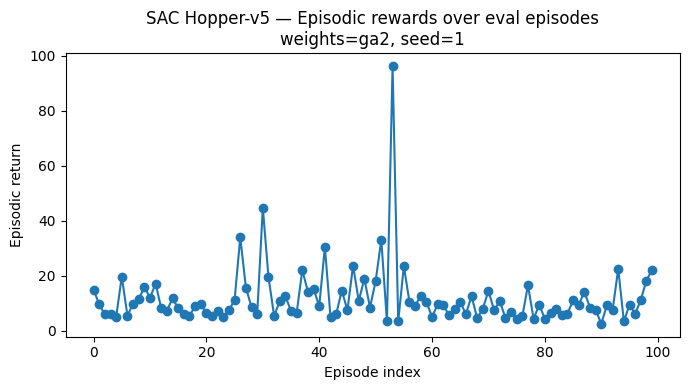

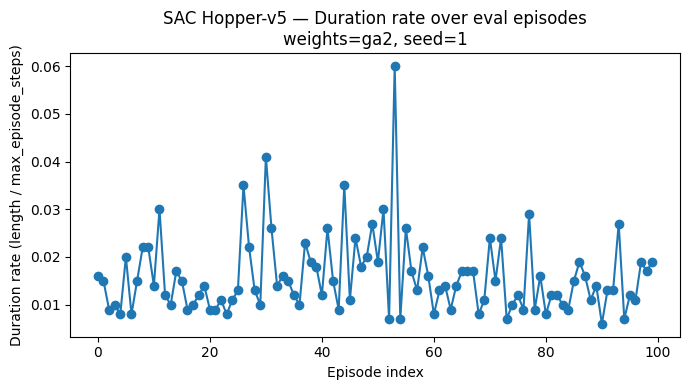

In [18]:
plt.figure(figsize=(7, 4))
plt.plot(
    agent_df["episode_index"],
    agent_df["episodic_return"],
    marker="o",
    linestyle="-",
)
plt.xlabel("Episode index")
plt.ylabel("Episodic return")
plt.title(
    f"{ALGO.upper()} {ENV_ID} — Episodic rewards over eval episodes\n"
    f"weights={AGENT_WEIGHTS}, seed={AGENT_SEED}"
)
plt.tight_layout()
plt.savefig(fr'{str(ROOT / "figures")}/{ALGO}_hopper_ep_rewards_over_eval_episodes', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(7, 4))
plt.plot(
    agent_df["episode_index"],
    agent_df["duration_rate"],
    marker="o",
    linestyle="-",
)
plt.xlabel("Episode index")
plt.ylabel("Duration rate (length / max_episode_steps)")
plt.title(
    f"{ALGO.upper()} {ENV_ID} — Duration rate over eval episodes\n"
    f"weights={AGENT_WEIGHTS}, seed={AGENT_SEED}"
)
plt.tight_layout()
plt.savefig(fr'{str(ROOT / "figures")}/{ALGO}_hopper_duration_rate_over_eval_episodes', dpi=300, bbox_inches='tight')
plt.show()
